### 1. Imports

In [227]:
import yfinance as yf  
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint
from keras.losses import MSE
from keras.optimizers import Adam
import os

sns.set()

### 2. Loading in Dataset

In [319]:
import matplotlib.pyplot as plt
df = yf.download('TSLA','2010-06-29','2019-05-28',interval='1d')


[*********************100%***********************]  1 of 1 downloaded


In [320]:
df1 = df.copy()

In [321]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,19.00,25.00,17.54,23.89,23.89,18766300
2010-06-30,25.79,30.42,23.30,23.83,23.83,17187100
2010-07-01,25.00,25.92,20.27,21.96,21.96,8218800
2010-07-02,23.00,23.10,18.71,19.20,19.20,5139800
2010-07-06,20.00,20.00,15.83,16.11,16.11,6866900


### 3. Preprocessing and Feature Extraction

In [322]:
df = df['Open'].values
df = df.reshape(-1, 1)
print(df.shape)
df[:5]

(2243, 1)


array([[19.  ],
       [25.79],
       [25.  ],
       [23.  ],
       [20.  ]])

In [283]:
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8)-50:])
print(dataset_train.shape)
print(dataset_test.shape)

(1794, 1)
(499, 1)


In [284]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_train[:10]

array([[0.00771826],
       [0.02604237],
       [0.0239104 ],
       [0.01851302],
       [0.01041695],
       [0.00070166],
       [0.        ],
       [0.00388612],
       [0.00488463],
       [0.00337336]])

In [285]:
dataset_test = scaler.transform(dataset_test)
dataset_test[:10]

array([[0.87337741],
       [0.86995007],
       [0.88668196],
       [0.91809472],
       [0.93809203],
       [0.96688706],
       [0.92254756],
       [0.94853596],
       [0.98488733],
       [0.96170557]])

In [286]:
def create_dataset(df):
    x = []
    y = []
  
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y 

In [287]:
x_train, y_train = create_dataset(dataset_train)
x_train[:2]

array([[0.00771826, 0.02604237, 0.0239104 , 0.01851302, 0.01041695,
        0.00070166, 0.        , 0.00388612, 0.00488463, 0.00337336,
        0.00485764, 0.01025503, 0.01230603, 0.01411415, 0.01540953,
        0.01219808, 0.01176629, 0.01362839, 0.01446498, 0.01287276,
        0.01190123, 0.01249494, 0.01095669, 0.01176629, 0.01311564,
        0.0156794 , 0.01457293, 0.01068682, 0.01014708, 0.00947241,
        0.00688166, 0.00447983, 0.00550533, 0.00623398, 0.00761031,
        0.00931048, 0.00647686, 0.00677371, 0.00796114, 0.00839293,
        0.00815005, 0.01012009, 0.00974227, 0.00960734, 0.00949939,
        0.00939145, 0.01141546, 0.01276481, 0.01206315, 0.01219808],
       [0.02604237, 0.0239104 , 0.01851302, 0.01041695, 0.00070166,
        0.        , 0.00388612, 0.00488463, 0.00337336, 0.00485764,
        0.01025503, 0.01230603, 0.01411415, 0.01540953, 0.01219808,
        0.01176629, 0.01362839, 0.01446498, 0.01287276, 0.01190123,
        0.01249494, 0.01095669, 0.01176629, 0.0

In [288]:
y_train[:3]

array([0.01311564, 0.01244097, 0.01281878])

In [289]:
x_test, y_test = create_dataset(dataset_test)
x_test[:2]

array([[0.87337741, 0.86995007, 0.88668196, 0.91809472, 0.93809203,
        0.96688706, 0.92254756, 0.94853596, 0.98488733, 0.96170557,
        0.9764944 , 0.9684523 , 0.97295911, 0.96669815, 0.97652139,
        0.98855755, 1.        , 0.97223047, 0.94599919, 0.95660505,
        0.93798408, 0.95560653, 0.89342869, 0.81262987, 0.8024828 ,
        0.80086358, 0.80922952, 0.84809068, 0.84730806, 0.82863311,
        0.83497504, 0.81327756, 0.84223452, 0.83864526, 0.84555391,
        0.84765889, 0.88749157, 0.87496964, 0.89019026, 0.86560518,
        0.861854  , 0.82812036, 0.81716368, 0.88838213, 0.89288895,
        0.9208204 , 0.92130617, 0.93067062, 0.93228984, 0.9197949 ],
       [0.86995007, 0.88668196, 0.91809472, 0.93809203, 0.96688706,
        0.92254756, 0.94853596, 0.98488733, 0.96170557, 0.9764944 ,
        0.9684523 , 0.97295911, 0.96669815, 0.97652139, 0.98855755,
        1.        , 0.97223047, 0.94599919, 0.95660505, 0.93798408,
        0.95560653, 0.89342869, 0.81262987, 0.8

In [290]:
y_test[:2]

array([0.94046687, 0.94200513])

In [291]:
# Reshape features for LSTM Layer
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [292]:
print(x_train.shape)
print(x_test.shape)


(1744, 50, 1)
(449, 50, 1)


### 4. Building Model

In [293]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [294]:
input_shape=(x_train.shape[1], 1)
print(input_shape)

(50, 1)


In [295]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 50, 96)            37632     
_________________________________________________________________
dropout_21 (Dropout)         (None, 50, 96)            0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 50, 96)            74112     
_________________________________________________________________
dropout_22 (Dropout)         (None, 50, 96)            0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 50, 96)            74112     
_________________________________________________________________
dropout_23 (Dropout)         (None, 50, 96)            0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 96)                74112     
__________

In [306]:
model.compile(loss=MSE, optimizer=Adam())

In [307]:
from keras.callbacks import ReduceLROnPlateau

checkpointer = ModelCheckpoint(filepath='tesla.stock_prediction.hdf5',save_best_only=True,verbose=1)

callbacks = [checkpointer, reduce_lr]

In [308]:

history = model.fit(x_train,y_train,batch_size=32,epochs=70,verbose=1,callbacks=[checkpointer],validation_split=0.05)


Train on 1656 samples, validate on 88 samples
Epoch 1/70
1656/1656 [==============================] - 22s 14ms/step - loss: 0.0027 - val_loss: 0.0102

Epoch 00001: val_loss improved from inf to 0.01024, saving model to tesla.stock_prediction.hdf5
Epoch 2/70
1656/1656 [==============================] - 14s 9ms/step - loss: 0.0020 - val_loss: 0.0134

Epoch 00002: val_loss did not improve from 0.01024
Epoch 3/70
1656/1656 [==============================] - 15s 9ms/step - loss: 0.0017 - val_loss: 0.0043

Epoch 00003: val_loss improved from 0.01024 to 0.00431, saving model to tesla.stock_prediction.hdf5
Epoch 4/70
1656/1656 [==============================] - 14s 9ms/step - loss: 0.0015 - val_loss: 0.0030

Epoch 00004: val_loss improved from 0.00431 to 0.00296, saving model to tesla.stock_prediction.hdf5
Epoch 5/70
1656/1656 [==============================] - 14s 8ms/step - loss: 0.0016 - val_loss: 0.0077

Epoch 00005: val_loss did not improve from 0.00296
Epoch 6/70
1656/1656 [=============


Epoch 00048: val_loss improved from 0.00074 to 0.00066, saving model to tesla.stock_prediction.hdf5
Epoch 49/70
1656/1656 [==============================] - 15s 9ms/step - loss: 8.4718e-04 - val_loss: 7.1374e-04

Epoch 00049: val_loss did not improve from 0.00066
Epoch 50/70
1656/1656 [==============================] - 15s 9ms/step - loss: 7.4590e-04 - val_loss: 0.0043

Epoch 00050: val_loss did not improve from 0.00066
Epoch 51/70
1656/1656 [==============================] - 16s 9ms/step - loss: 8.2506e-04 - val_loss: 9.2117e-04

Epoch 00051: val_loss did not improve from 0.00066
Epoch 52/70
1656/1656 [==============================] - 15s 9ms/step - loss: 7.5005e-04 - val_loss: 7.0608e-04

Epoch 00052: val_loss did not improve from 0.00066
Epoch 53/70
1656/1656 [==============================] - 15s 9ms/step - loss: 9.7618e-04 - val_loss: 0.0012

Epoch 00053: val_loss did not improve from 0.00066
Epoch 54/70
1656/1656 [==============================] - 15s 9ms/step - loss: 7.6028e-0

In [309]:
model = load_model('tesla.stock_prediction.hdf5')

### 5. Visualizing Results

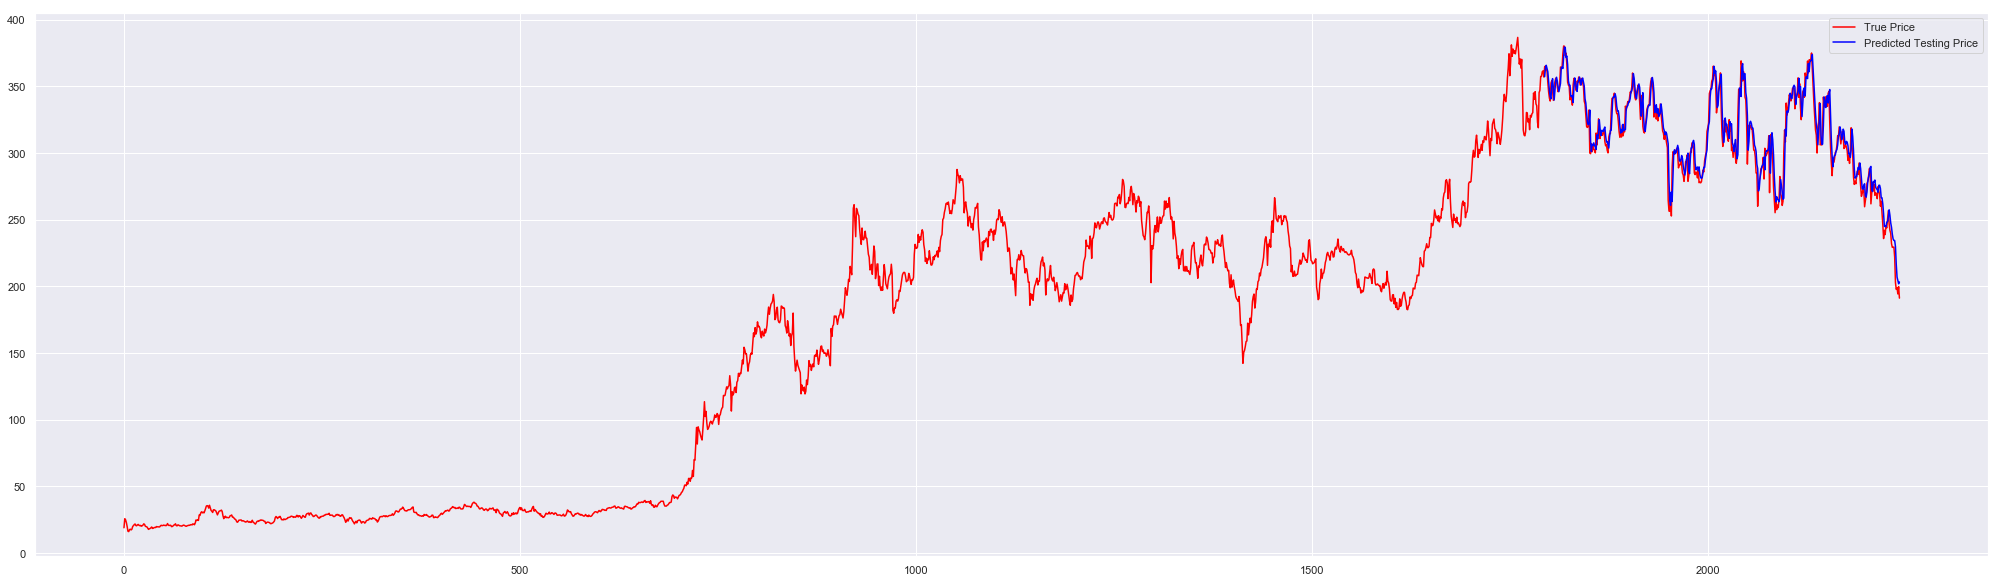

In [310]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

fig, ax = plt.subplots(figsize=(35,10))
plt.plot(df, color='red',  label="True Stock Price",)
ax.plot(range(len(y_train)+50,len(y_train)+50+len(predictions)),predictions, color='blue', label='Predicted Stock Price')
plt.legend()



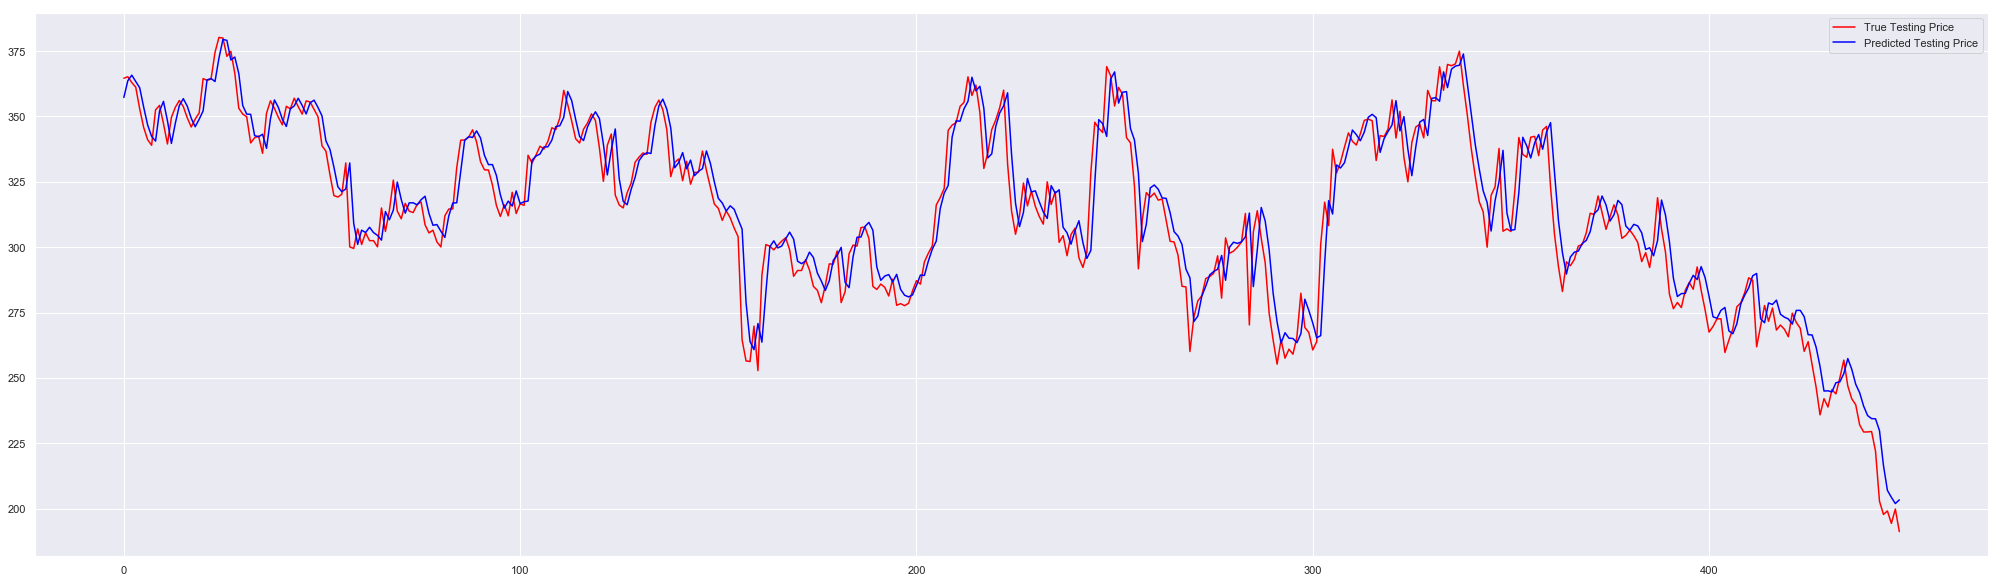

In [311]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))


fig, ax = plt.subplots(figsize=(35,10))
ax.plot(y_test_scaled, color='red', label='True Stock Price')
plt.plot(predictions, color='blue', label='Predicted Stock Price')
plt.legend()

In [324]:
df1.reset_index(inplace=True)


In [325]:
df1.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.00,25.00,17.54,23.89,23.89,18766300
1,2010-06-30,25.79,30.42,23.30,23.83,23.83,17187100
2,2010-07-01,25.00,25.92,20.27,21.96,21.96,8218800
3,2010-07-02,23.00,23.10,18.71,19.20,19.20,5139800
4,2010-07-06,20.00,20.00,15.83,16.11,16.11,6866900


In [326]:
df1.reset_index(inplace=True)
k = df1[['Date','Open']].iloc[len(y_train)+50 :] 
k['Predictions'] = predictions
k.head()

,Date,Open,Predictions
1794,2017-08-14,364.63,357.275391
1795,2017-08-15,365.20,363.674561
1796,2017-08-16,363.00,365.794830
1797,2017-08-17,361.21,363.396393
1798,2017-08-18,352.91,360.979156


In [327]:
from sklearn.metrics import mean_absolute_error

In [328]:
mean_absolute_error(k['Open'],k['Predictions'])
 

7.51922814723909